# Learning Vector Quantization applied to text classification

Learning Vector Quantization (Kohonen 1986, cf. Kohonen 1998) is a supervised classification approach. 
LVQ is a prototype-based competitive learning network that learns prototypes
by moving 'winning' prototypes into the direction of the respective data point (and moving 'loosing'
prototypes in the opposite direction). The prototypes are defined in the feature space of the input data,
which makes LVQ models more readily interpretable by domain experts than other neural network approaches.
Martín-Valdivia, Ureña-López and García-Vega (2007) applied LVQ to textual data in two different classification tasks,
namely text categorization and word sense disambiguation, and showed that it yields superior performance in comparison
to other common algorithms such as Naive Bayes, SVMs and k-NN.

Following this line of research, I will report on a experiment in text classfication using the LVQ implementation
provided by [Neurolab](https://github.com/zueve/neurolab) ([example](https://pythonhosted.org/neurolab/ex_newlvq.html)). While LVQ exists in various improved variants, 
Ńeurolab only implements the basic version as originally proposed by Kohonen (LVQ1). There is one major difference tough. Unlike the original learning algorithm, the Neurlab [implementation](https://github.com/zueve/neurolab/blob/master/neurolab/train/lvq.py) does not select training examples randomly. A workaround is to shuffle the training data before training and do several runs.

## Dataset - DBMail newsletter

The [data set](https://archive.ics.uci.edu/ml/datasets/DBWorld+e-mails) used in the experiment is a collection of emails from the ACM SIGMOD [DBWorld newsletter](https://research.cs.wisc.edu/dbworld/). It was created by [Michele Filannino](http://www.michelefilannino.com/) in the context of a machine learning term [paper](https://archive.ics.uci.edu/ml/datasets/%3Ca%20href=%22http://www.cs.man.ac.uk/~filannim/dbworld_email_classification.pdf%22%3E[Web%20Link]%3C/a%3E) (Filannino 2011). The data set contains 64 emails in one-hot representation seperated into subsets containing only bodies or subjects. Each subset is also available in a [stemmed](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) version, which was produced using Porter's algorithm (Porter 1980). The size of the vocabulary (or dimensionality) is...

## Imports

In [1]:
%matplotlib inline

import csv
from random import shuffle

import numpy as np
import neurolab as nl
from matplotlib import pylab as plt
from sklearn.manifold import TSNE

## Preprocessing

In [56]:
def encode_labels(labels):
    target = []
    for label in labels:
        if label == 0.0:
            target.append([1.0,1.0,0.0,0.0])
        elif  label == 1.0:
            target.append([0.0,0.0,1.0,1.0])
    return target

def decode_labels(targets):
    labels = []
    for target in targets:
        if np.array_equal(target, [1.0,1.0,0.0,0.0]):
            labels.append(0.0)
        elif np.array_equal(target, [0.0,0.0,1.0,1.0]):
            labels.append(1.0)
    return labels

def load_data(path):
    data = []
    labels = []
    feature_names = []
    with open(path) as f:
        reader = csv.reader(f, delimiter=',',)
        header = reader.next()
        feature_names = header[:-1] # header without CLASS
        for row in reader:
            row_values = map(float, row)
            label = row_values.pop()
            labels.append(label)
            data.append(row_values)
    return (data, encode_labels(labels), feature_names)

In [57]:
TRAIN_TEST_SPLIT = -14

In [58]:
original_data, original_target, feature_names = load_data('dbworld_subjects.csv')
original_train_data = original_data[:TRAIN_TEST_SPLIT]
original_train_target = original_target[:TRAIN_TEST_SPLIT]
original_test_data = original_data[TRAIN_TEST_SPLIT:]
original_test_target = original_target[TRAIN_TEST_SPLIT:]

In [59]:
def shuffle_labeled_data(original_data, original_target):
    shuffled = zip(original_data, original_target)
    shuffle(shuffled)
    data = np.array([data for data, _ in shuffled])
    target = np.array([target for _, target in shuffled])
    return data, target

In [60]:
train_data, train_target = shuffle_labeled_data(original_train_data, original_train_target)
test_data, test_target = shuffle_labeled_data(original_test_data, original_test_target)

In [61]:
train_N, num_dimensions = train_data.shape
test_N, _ = test_data.shape
print 'train (N,d): ', train_N, num_dimensions
print 'test (N,d): ', test_N, num_dimensions


train (N,d):  50 242
test (N,d):  14 242


## Setting up LVQ 

Create network with 2 layers: d neurons (i.e. as man neurons as dimensions) in input layer (competitive) and 2 neurons (i.e. as many neurons as classes) in output layer (perceptrons with linear transition)

In [62]:
net = nl.net.newlvq(nl.tool.minmax(train_data), num_dimensions, [0.25, 0.25, 0.25, 0.25])
error = net.train(train_data, train_target, epochs=500, lr=0.1, goal=0.3)

Epoch: 100; Error: 0.5;
Epoch: 200; Error: 0.52;
Epoch: 300; Error: 0.5;
Epoch: 400; Error: 0.5;
Epoch: 500; Error: 0.5;
The maximum number of train epochs is reached


## Visualization

In [63]:
def get_prototypes(net):
    return net.layers[1].np['w']

In [64]:
tsne = TSNE(n_components=2, random_state=0, init='pca')
train_embedding = tsne.fit_transform(train_data)
test_embedding = tsne.fit_transform(test_data)
embedded_protos = tsne.fit_transform(get_prototypes(net))

In [65]:
print embedded_protos

[[ 107.34167508   95.35297326]
 [ -96.69950742  -95.31120762]
 [ -86.53072151   98.26667099]
 [  97.10576068  -98.22222511]]


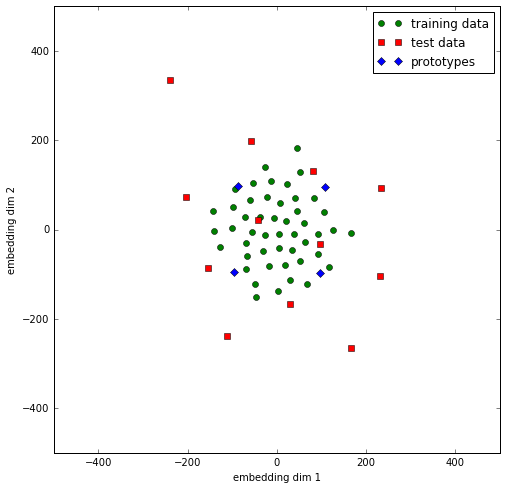

In [66]:
plt.figure(figsize=(8,8))
plt.plot(train_embedding[:,0], train_embedding[:,1], 'go')
plt.plot(test_embedding[:,0], test_embedding[:,1], 'rs')
plt.plot(embedded_protos[:,0], embedded_protos[:,1], 'bD')
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('embedding dim 1')
plt.ylabel('embedding dim 2')
plt.legend(['training data', 'test data', 'prototypes'])
plt.show()

## Evaluation

In [67]:
output = net.sim(test_data)

In [68]:
class_counts = [0,0]
for labels in test_target:
    if np.array_equal(labels, [1.0, 1.0, 0.0, 0.0]):
        class_counts[0] += 1
    else:
        class_counts[1] += 1
print 'Majority baseline: ', np.max(class_counts) / float(len(test_target))

Majority baseline:  0.714285714286


In [69]:
def evaluate(output, test_target):
    right = 0
    for i, labels in enumerate(output):
        if np.array_equal(labels, test_target[i]):
            right += 1
    print 'Accuracy: ', right / float(len(test_target))
evaluate(output, test_target)

Accuracy:  0.0


In [70]:
def get_prototype_words_and_labels(net, feature_names):
    # the prototypes are the weights of the second layer
    labeled_bags_of_words = []
    prototypes = net.layers[1].np['w']
    for prototype in prototypes:
        bag_of_words = []
        for index, entry in enumerate(prototype):
            if entry == 1:
                bag_of_words.append(feature_names[index])
        label = 'CFP' if decode_labels(net.sim([prototype]))[0] == 1 else 'NON-CFP'
        labeled_bags_of_words.append((label, bag_of_words))
    return labeled_bags_of_words

labeled_bags_of_words = get_prototype_words_and_labels(net, feature_names)
for label, bag_of_words in labeled_bags_of_words:
    print label
    print bag_of_words

IndexError: list index out of range

In [48]:
def crossfold(data, target, k, epochs):
    
    split = len(data) / k

    for i in range(k):
        test_start = i * split
        test_end = (i+1) * split
        train_start = test_end
        train_end = len(data)

        test_data = data[test_start:test_end]
        train_data = data[train_start:train_end]
        
        test_target = target[test_start:test_end]
        train_target = target[train_start:train_end]
        
        second_train_start = 0
        second_train_end = 0
        
        print 'k: ', i

        if i > 0:
            second_train_end = test_start
            train_data = np.vstack([train_data, data[second_train_start:second_train_end]])
            train_target = np.vstack([train_target, target[second_train_start:second_train_end]])
            print 'train range: ', second_train_start, '-', second_train_end, ' | ', train_start, '-' , train_end
        else:
            print 'train range: ', train_start, '-' , train_end
            
        print 'test range: ', test_start, '-', test_end
            
        net = nl.net.newlvq(nl.tool.minmax(train_data), 242, [.5, .5])
        error = net.train(train_data, train_target, epochs=epochs, lr=0.1, goal=-1)
        
        output = net.sim(test_data)
        evaluate(output, test_target)

crossfold(data, target, 3, 200)

NameError: name 'data' is not defined

## Conclusion

Limited by technology choice, need for more evolved implementations

## References

Kohonen, T.: 1986, Learning vector quantization for pattern recognition, Technical Report TKK-
F-A601, Helsinki Univeristy of Technology, Espoo, Finland.

Kohonen, T.: 1998, Learning vector quantization, The handbook of brain theory and neural net-
works, MIT Press, Cambridge, MA, USA, pp. 537–540

Martín-Valdivia, M. T., Ureña-López, L. A., & García-Vega, M.: 2007, The Learning Vector Quantization Algorithm Applied to
Automatic Text Classification Tasks. Neural Netw., 20(6), 748–756. http://doi.org/10.1016/j.neunet.2006.12.005

Michele Filannino, 'DBWorld e-mail classification using a very small corpus', Project of Machine Learning course, University of Manchester, 2011.

Neurolab. Retrieved July 8, 2016, from https://github.com/zueve/neurolab

Porter, Martin F. 1980. An algorithm for suffix stripping. Program 14 (3): 130-137. 